# 5. Use a modified MNIST dataset to train our model using handwritten recognition.

Make sure to install cv2 and tensorflow libraries before importing!!!

In [1]:
#Import all the libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

In [2]:
# import our dataset using tensorflow
mnist = tf.keras.datasets.mnist

### Preprocessing

In [3]:
# Jason's 20 x 16 dataset

dim = 28
    
def getHandwrittenData(path="handwritten_training_data.png", verbose=False, displayOrig=True, factor=1):
    img = cv2.imread(path)[:,:,0]

    if displayOrig:
        temp = np.invert(np.array([img]))
        plt.imshow(temp[0], cmap=plt.cm.binary)
        plt.show()
    
    resInput = [None]*16
    for row in range(16):
        cur = [None]*20
        for col in range(20):
            sub = img[row*29+1:row*29+29, col*29+1:col*29+29]
            sub = np.invert(np.array([sub]))
    
            cur[col]=sub
            if verbose:
                plt.imshow(sub[0], cmap=plt.cm.binary)
                plt.show()
        resInput[row] = cur

    resOutput = [None]*(20*16)
    for i in range(16):
        output = [0] * 16
        output[i]=1
        for idx in range(i*20, i*20+20):
            resOutput[idx]=output
    resInput = resInput * factor
    resOutput = resOutput * factor
    return resInput, resOutput
# getHandwrittenData()

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add handwritten special characters to MNIST
resInput, _ = getHandwrittenData(path="handwritten_training_data.png", verbose=False, displayOrig=False)

# 3/20 of handwritten data will go to test
x_train_add, x_test_add = [], []
y_train_add, y_test_add = [], []
for label in range(10, 16):
    x_train_add += resInput[label][:17]
    y_train_add += [label]*17
    x_test_add += resInput[label][17:]
    y_test_add += [label]*3

# Add data into x_train and x_test
train_scale = (6*len(x_train)//10) // len(x_train_add)
test_scale = (6*len(x_test)//10) // len(x_test_add)

x_train_add = tf.reshape(x_train_add * (train_scale*17//20), (-1, 28, 28))
x_train = np.append(x_train, x_train_add, axis=0)

x_test_add = tf.reshape(x_test_add * (test_scale*3//20), (-1, 28, 28))
x_test = np.append(x_test, x_test_add, axis=0)

y_train_add = tf.reshape(y_train_add * (train_scale*17//20), (-1))
y_train = np.append(y_train, y_train_add, axis=0)

y_test_add = tf.reshape(y_test_add * (test_scale*3//20), (-1))
y_test = np.append(y_test, y_test_add, axis=0)

# Scramble data, to ensure data is evenly spread out
sklearn.utils.shuffle(x_train, y_train, random_state=6)
sklearn.utils.shuffle(x_test, y_test, random_state=6)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(90498, 28, 28)
(10882, 28, 28)
(90498,)
(10882,)


In [5]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [6]:
def createModel(hiddenLayers=[128, 128], dropoutRate=0, activation='relu', optimizer='adam',
                loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    
    # Creating hidden layers
    for count in hiddenLayers:
        model.add(tf.keras.layers.Dense(count, activation=activation))
        model.add(tf.keras.layers.Dropout(dropoutRate))
    
    # Output layer with 16 neurons
    model.add(tf.keras.layers.Dense(16, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

### Training the model with a set seed

In [7]:
# Funney
seed = hash("Group6TheBest") % (10**9 + 7)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()
model = createModel(hiddenLayers=[512, 96])
model.fit(x_train, y_train, epochs=6, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7737 - loss: 0.8719 - val_accuracy: 0.9609 - val_loss: 0.1173
Epoch 2/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.9749 - loss: 0.0837 - val_accuracy: 0.9777 - val_loss: 0.0699
Epoch 3/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9851 - loss: 0.0508 - val_accuracy: 0.9827 - val_loss: 0.0513
Epoch 4/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.9891 - loss: 0.0350 - val_accuracy: 0.9851 - val_loss: 0.0461
Epoch 5/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9922 - loss: 0.0267 - val_accuracy: 0.9864 - val_loss: 0.0428
Epoch 6/6
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.9938 - loss: 0.0208 - val_accuracy: 0.9865 - val_loss: 0.0456


In [8]:
loss, accuracy = model.evaluate(x_test, y_test)

341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9823 - loss: 0.0588


In [9]:
print(loss)
print(accuracy)

0.04564841091632843
0.9864914417266846


## Testing it with my own handwritten numbers

Processing: jason_digits/digit0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
This digit is probably a 0


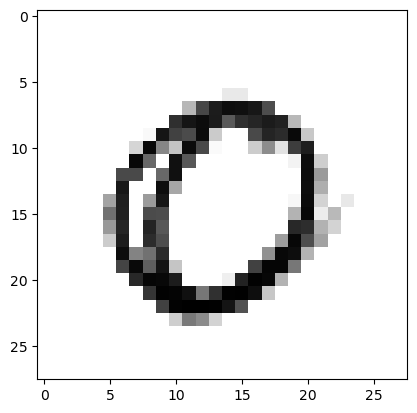

Processing: jason_digits/digit1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
This digit is probably a 1


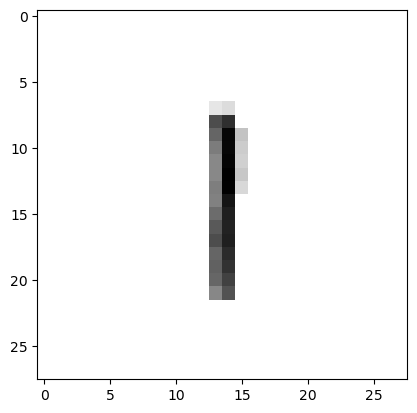

Processing: jason_digits/digit2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
This digit is probably a 2


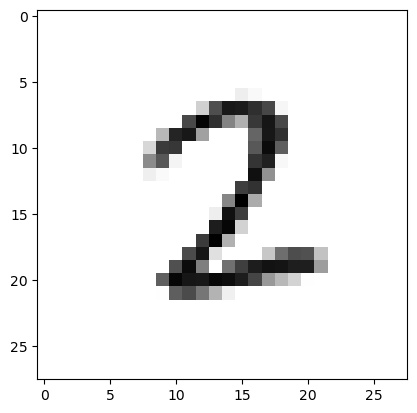

Processing: jason_digits/digit3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
This digit is probably a 3


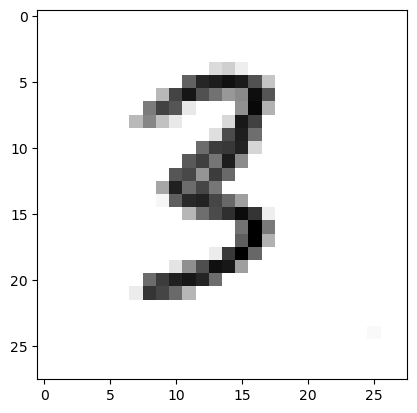

Processing: jason_digits/digit4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
This digit is probably a 4


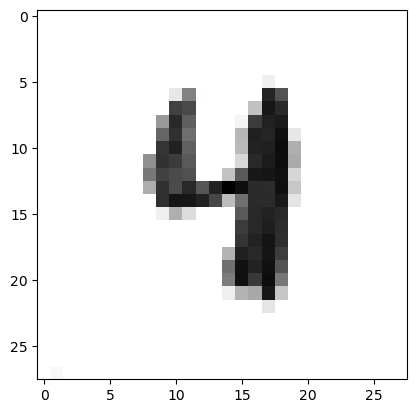

Processing: jason_digits/digit5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This digit is probably a 5


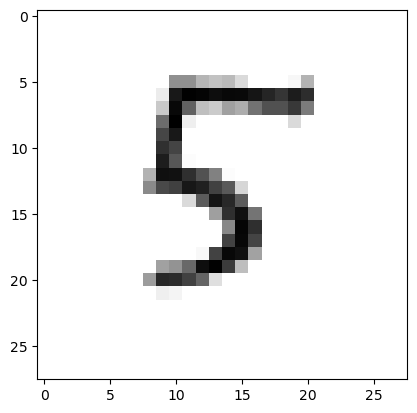

Processing: jason_digits/digit6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
This digit is probably a 6


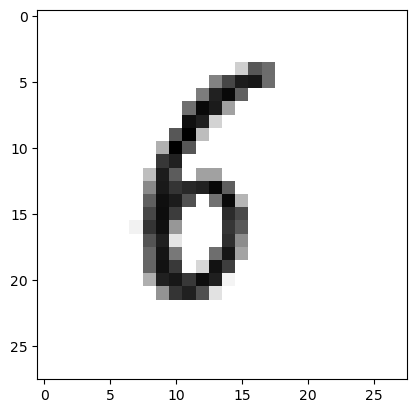

Processing: jason_digits/digit7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
This digit is probably a 7


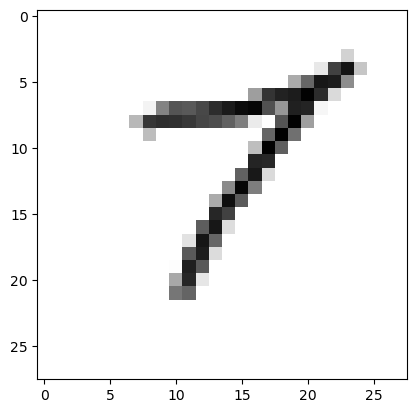

Processing: jason_digits/digit8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
This digit is probably a 8


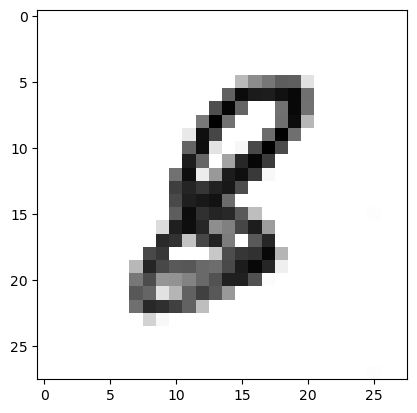

Processing: jason_digits/digit9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This digit is probably a 8


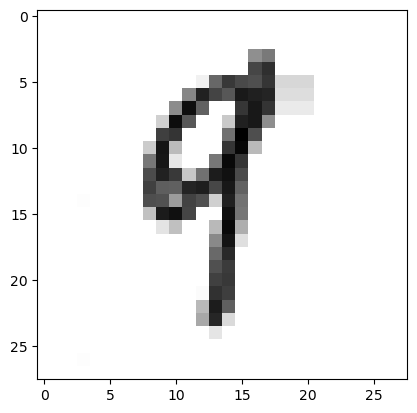

In [10]:
image_number = 1

# Enable interactive mode for matplotlib
plt.ion()

image_number = 0
# folder_name = "digits_samples"
folder_name = "jason_digits"

while os.path.isfile(f"{folder_name}/digit{image_number}.png"):
    try:
        # Debugging statement
        print(f"Processing: {folder_name}/digit{image_number}.png")
        
        img = cv2.imread(f"{folder_name}/digit{image_number}.png")[:,:,0]
        img = np.invert(np.array([img]))
        
        # Ensure the image is correctly read and processed
        if img is not None:
            prediction = model.predict(img)
            print(f"This digit is probably a {np.argmax(prediction)}")
            plt.imshow(img[0], cmap=plt.cm.binary)
            plt.show()
        else:
            print(f"Failed to load image {folder_name}/digit{image_number}.png")
            
    except Exception as e:
        print(f"Error: {e}")
    finally:
        image_number += 1

# Turn off interactive mode
plt.ioff()

### Parse some expression

In [11]:
import cv2
import numpy as np
dim = 28

def isEmpty(imgBin):
    imgBin = imgBin[0]
    for row in imgBin:
        if row.tolist().count(0)!=dim: return False
    return True
    
def splitExpression(path="expression0.png", verbose=False, displayOrig=True):
    img = cv2.imread(path)[:,:,0]
    divs = img.shape[1]//dim

    if displayOrig:
        temp = np.invert(np.array([img]))
        plt.imshow(temp[0], cmap=plt.cm.binary)
        plt.show()
    res = []
    for i in range(divs):
        sub = img[1:dim+1, i*29+1:i*29+1+dim]
        sub = np.invert(np.array([sub]))
        
        if isEmpty(sub): break

        res.append(sub)
        if verbose:
            plt.imshow(sub[0], cmap=plt.cm.binary)
            plt.show()
    return res

lookup = [str(i) for i in range(10)] + list("+-*/()")
def getToken(img, verbose=False):
    return lookup[np.argmax(model.predict(img, verbose=verbose))]

def parseExpression(path="expression0.png", verbose=False, displayOrig=True):
    images = splitExpression(path=path, verbose=verbose)
    return "".join(map(getToken, images))

In [12]:
def getAccuracy(path="tokens0.png", includeSpecialChars=True):
    length = 16 if includeSpecialChars else 10
    res = parseExpression(verbose=0, path=path)
    exp = "".join(lookup)
    mismatch = [" "]*length
    acc=0
    for i in range(length):
        if res[i]==exp[i]: acc+=1
        else: mismatch[i]="^"
    print(exp[:length])
    print(res[:length])
    print("".join(mismatch))
    print("Accuracy:", acc/length)

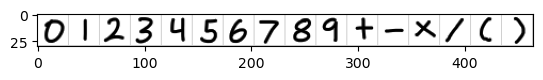

0123456789+-*/()
01234567891-*/()
          ^     
Accuracy: 0.9375


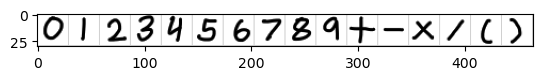

0123456789+-*/()
0123456789+-*1()
             ^  
Accuracy: 0.9375


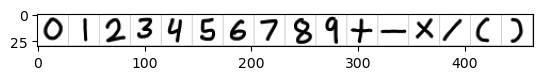

0123456789+-*/()
0123456784+-*/()
         ^      
Accuracy: 0.9375


In [13]:
getAccuracy("tokens0.png")
getAccuracy("tokens1.png")
getAccuracy("tokens2.png")

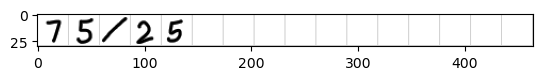

75/25
3.0


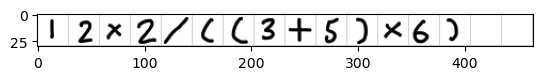

12*2/((3+5)*6)
0.5


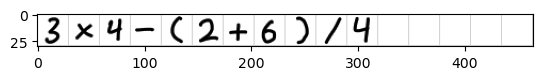

3*4-(2+6)/4
10.0


In [18]:
import traceback

def solve(path):
    try:
        expr = parseExpression(path=path)
        print(expr)
        print(eval(expr))
    except:
        traceback.print_exc()
for i in range(3): solve(f"expression{i}.png")